# Data Analysis of the Seattle Airbnb data set

## Structure of this analysis

This analysis tries to answer 3 questions.
The outline is structured in 
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling (for Question 3)
5. Evaluation

NOTE: The The Data Preparation & the Evaluation is divided in sections for Question 1-3. 
In the Evaluation the questions are answered

## Business Understanding

In this analysis, I want to use the Seattle Airbnb Dataset to find out different reasons for prices to increase or decrease. This is an important question for both visitors and apartment hosts. 

Within this overall goal of this analysis, I am trying to anser the 3 following questions:
1. In which season do prices in Seattle climax?
2. Which areas of the city are most affected by the price spike?
3. Which attributes have the biggest impact on prices?

## Data Understanding 

In [1]:
# import the neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

**Gather** - the data

In [2]:
# Download the csv.Files from https://www.kaggle.com/airbnb/seattle 
# and save it into the same folder you saved this file "Data Analysis.ipynb" into
# Then run this cell

calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")

# The review.csv is also part of the Seattle Airbnb dataset, however not used in this analysis
#reviews = pd.read_csv("reviews.csv")

# Change settings so you can see all of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


**Assess** - the data

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
# What data types do we have in the dataset?
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


We see price is an object at the moment. In order to work with it, we will have to change it into a float later.


In [5]:
# Are there missing values?
calendar.isnull().mean()

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

There are 32,9% of the cells missing a value for the price. We will have to find a way to fill the missing values later in the Data preparation

In [6]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In a lot of columns we find "t" and "f" that symbolize True and False. In order to work with this, we will have to change the values from "t" into 1 and "f" into 0 later in the Preparation

In [7]:
# Examine the data types of the columns
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [8]:
# How many missing values are there for each column?
listings.isnull().mean().sort_values(ascending=False)

license                             1.000000
square_feet                         0.974594
monthly_price                       0.602672
security_deposit                    0.511262
weekly_price                        0.473808
notes                               0.420639
neighborhood_overview               0.270299
cleaning_fee                        0.269775
transit                             0.244631
host_about                          0.224987
host_acceptance_rate                0.202462
review_scores_accuracy              0.172342
review_scores_checkin               0.172342
review_scores_value                 0.171818
review_scores_location              0.171556
review_scores_cleanliness           0.171032
review_scores_communication         0.170508
review_scores_rating                0.169460
reviews_per_month                   0.164222
first_review                        0.164222
last_review                         0.164222
space                               0.149031
host_respo

We see that "square_feet" and "license" have almost all values missing. It will be very difficult to use these valriables for answeing the questions.

## Data preparation

For question 1. In which season do prices in Seattle climax?

- I want to use the calendar dataset to see in which season prices in Seattle climax.
- We therefore need the price column streamlined into floats and we have to fill the missing values.
- Furthermore we need the date in year and month to look for anomalies on a monthly basis.

For question 2. Which areas of the city are most affected by the price spike?

- To answer this question, we will need the respective area to a listing, which is found in the listing dataset unser the variable "neighbourhood_group_cleansed" --> we will need to left join this to the calendar Data Frame

For question 3. Which attributes have the biggest impact on prices?

- For answering this question, I will perform a linear regression. To do that, we will need to fill missing values, transform categorial into dummies and drop rows

### Preparation: Question 1 & Question 2

In [9]:
"""Functions for Cleaning Data"""

def correction (x):
    """
    Make string columns to floats -> e.g. "85.00$" into 85.00
    """
    if type(x) == str:
        
        x = x.replace(",","")
        
        x = x.replace("$","")
        
        x = x.replace("%", "")
        
        x = float(x)    
    return (x)


**Cleaning** - the data for Question 1 and 2

In [10]:
# Creating column that contents the year and the month
calendar["date_year_month"] = calendar["date"].apply(lambda x: x[:-3])

# Join price & neighborhood column to the calendar DataFrame
calendar = pd.merge(left = calendar, 
                   right = listings[["id", "price", "neighbourhood_group_cleansed"]],
                   left_on = "listing_id", 
                   right_on = "id", 
                   how = "left")

# Fill the missing values for the price column in the Calendar DataFrame withthe prices from the listings DataFrame
# that means, mising values for listings in the calendar will be filled with the general price for the apartment from the listings data set
calendar["price_x"] = calendar["price_x"].fillna(calendar["price_y"])

# Clean the price column
calendar["price_x"] = calendar["price_x"].apply(lambda x: correction(x))

# Rename columns and drop unneccessary ones that are not needed for further analysis
calendar = calendar.rename(columns = {"price_x": "price", "neighbourhood_group_cleansed": "area"}).drop(labels = "price_y", axis = 1)

# Change the name of "Other neighborhoods" into "Other areas" to be consistent
calendar["area"] = calendar["area"].apply(lambda x: "Other areas" if x == "Other neighborhoods" else x)

calendar.head()

,listing_id,date,available,price,date_year_month,id,area
0,241032,2016-01-04,t,85.0,2016-01,241032,Queen Anne
1,241032,2016-01-05,t,85.0,2016-01,241032,Queen Anne
2,241032,2016-01-06,f,85.0,2016-01,241032,Queen Anne
3,241032,2016-01-07,f,85.0,2016-01,241032,Queen Anne
4,241032,2016-01-08,f,85.0,2016-01,241032,Queen Anne


### Preparation: Question 3. Which attributes have the biggest impact on prices?

In [11]:
# We need a function for the "host_since" column, that returns us the number of years a host has been host in 2017. 
def get_year(x):
    
    """
    INPUT: year as input
    OUTPUT: Return the difference between input year and 2016
    """
    if type(x) != float:
        x = x.split("-")[0]
    
    return 2017-float(x)


# Lambda function to fill missing values with the mean of the column
fill_mean = lambda col: col.fillna(col.mean())

# turn strings for true and false "t" and "f" into 1 and 0
t_F_handling = lambda x: 1 if x =="t" else 0


# Function for turning categorial variables in a DataFrame into dummies
def prepare_df(df, consider_na):
    
    """
    INPUT 
        df [DataFrame]: The dataframe including the catecorial variables that are to be turned into dummies
        consider_na [bool]: Wheather or not Nan values should get an own column of dummies
    OUTPUT:
        The Dataframe df with the categorial columns turned into dummies and the origin column dropped
        """
    df = df.dropna(subset = ["price"], axis = 0)
    cat_vars = df.select_dtypes(include = ["object"]).copy().columns
    
    for i in cat_vars:
        df = pd.concat([df.drop(labels = i, axis = 1), pd.get_dummies(data = df[i], dummy_na = consider_na, prefix = i, prefix_sep = "_", drop_first = True)],axis = 1)
        
    return df



**Cleaning** - the data for Question 3

In [12]:
# Run this code just once, else you will have some columns with just zeros because of the t_F_handling function that is applied
# Turning t into 1 and f into 0 for True and False
listings["host_has_profile_pic"] = listings["host_has_profile_pic"].apply(t_F_handling)
listings["host_is_superhost"] = listings["host_is_superhost"].apply(t_F_handling)
listings["host_identity_verified"] = listings["host_identity_verified"].apply(t_F_handling)
listings["instant_bookable"] = listings["instant_bookable"].apply(t_F_handling)

# Correction of the price, turn strings into the correct floats
listings["price"] = listings["price"].apply(lambda x :correction(x))

# Same with the host response rate, that is saved as a string in the origin Dataframe
listings["host_response_rate"]= listings["host_response_rate"].apply(lambda x: correction(x))

# Fill NAN with Mean for numeric variables
listings[["host_response_rate"]] = listings[["host_response_rate"]].apply(fill_mean, axis = 0)
listings[["bathrooms"]] = listings[["bathrooms"]].apply(fill_mean, axis = 0)
listings[["bedrooms"]] = listings[["bedrooms"]].apply(fill_mean, axis = 0)
listings[["beds"]] = listings[["beds"]].apply(fill_mean, axis = 0)
listings[["review_scores_rating"]] = listings[["review_scores_rating"]].apply(fill_mean, axis = 0)
listings[["reviews_per_month"]] = listings[["reviews_per_month"]].apply(fill_mean, axis = 0)

# Make years out of the date for the variable "host since"
listings["host_since_streamlined"] = listings["host_since"].apply(lambda x:get_year(x))

# rename area_group_cleansed into area, because its shorter later as part of the coefficients
listings = listings.rename(columns = {"neighbourhood_group_cleansed":"area"})

# Change the name of "Other neighborhoods" into "Other areas" to be consistent
listings["area"] = listings["area"].apply(lambda x: "Other areas" if x == "Other neighborhoods" else x)

In [13]:
# Number of NA's in the columns for columns with very few values missing
listings[["host_since_streamlined", "host_listings_count", "host_has_profile_pic", "property_type"]].isnull().sum()

host_since_streamlined    2
host_listings_count       2
host_has_profile_pic      0
property_type             1
dtype: int64

In [14]:
# drop na's from columns where just very few values in rows are missing 
listings.dropna(axis = 0, subset = ["host_since_streamlined", "host_listings_count", "host_has_profile_pic", "property_type"], inplace = True)

# categorial variables to be considered in the regression
cat_var = ["area", "property_type", "room_type", "bed_type","cancellation_policy"]




In [15]:
# Columns that I want to consider in the regression model. 
# These columns still contain categorial variables that have to be transformed still

columns = [
    "price","host_since_streamlined","host_response_rate",
    "host_is_superhost", "host_listings_count","host_identity_verified",
    "area","property_type", "accommodates",
    "bathrooms","bedrooms","beds",
    "bed_type","number_of_reviews", "review_scores_rating",
    "instant_bookable","cancellation_policy", "reviews_per_month"
]

# cleaned dataset (categorial vairables still have to become dummy variables)
listings[columns].head()

,price,host_since_streamlined,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,area,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,85.0,6.0,96.000000,0,3.0,1,Queen Anne,Apartment,4,1.0,1.0,1.0,Real Bed,207,95.000000,0,moderate,4.070000
1,150.0,4.0,98.000000,1,6.0,1,Queen Anne,Apartment,4,1.0,1.0,1.0,Real Bed,43,96.000000,0,strict,1.480000
2,975.0,3.0,67.000000,0,2.0,1,Queen Anne,House,11,4.5,5.0,7.0,Real Bed,20,97.000000,0,strict,1.150000
3,100.0,4.0,94.886798,0,1.0,1,Queen Anne,Apartment,3,1.0,0.0,2.0,Real Bed,0,94.539262,0,flexible,2.078919
4,450.0,6.0,100.000000,0,2.0,1,Queen Anne,House,6,2.0,3.0,3.0,Real Bed,38,92.000000,0,strict,0.890000


In [16]:
# Prepared listing dataset (turn categorial vars into dummies)
clean_listings = prepare_df(df = listings[columns], consider_na = False)

# columns with more than .5% specifications considered in regression --> 
# Dummy variables with less than 0.5% 1s not included in regression
columns_to_consider = clean_listings.columns[clean_listings.describe().loc["mean"] >0.005]
clean_listings = clean_listings[columns_to_consider]
clean_listings.head()

,price,host_since_streamlined,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,area_Beacon Hill,area_Capitol Hill,area_Cascade,area_Central Area,area_Delridge,area_Downtown,area_Lake City,area_Magnolia,area_Northgate,area_Other areas,area_Queen Anne,area_Rainier Valley,area_Seward Park,area_University District,area_West Seattle,property_type_Bed & Breakfast,property_type_Cabin,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,85.0,6.0,96.000000,0,3.0,1,4,1.0,1.0,1.0,207,95.000000,0,4.070000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,150.0,4.0,98.000000,1,6.0,1,4,1.0,1.0,1.0,43,96.000000,0,1.480000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,975.0,3.0,67.000000,0,2.0,1,11,4.5,5.0,7.0,20,97.000000,0,1.150000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
3,100.0,4.0,94.886798,0,1.0,1,3,1.0,0.0,2.0,0,94.539262,0,2.078919,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,450.0,6.0,100.000000,0,2.0,1,6,2.0,3.0,3.0,38,92.000000,0,0.890000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1


## Modelling (for Question 3)

**Model** - the regression to be used later on 

In [17]:
# Define X and y
X = clean_listings.drop("price", axis = 1)
y = clean_listings["price"]

# Split into train, test and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Create and fit, normalized variables
lm_model= LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
  


LinearRegression(normalize=True)

## Evaluation

### Question 1. In which season do prices in Seattle climax?

**Analyze** - the average price of apartments over different months

In [18]:
# Average price of all listings per month
season= calendar[["price", "date_year_month"]].groupby(by="date_year_month").mean().reset_index()

season

,date_year_month,price
0,2016-01,125.713855
1,2016-02,127.590714
2,2016-03,131.101151
3,2016-04,133.527894
4,2016-05,136.622696
5,2016-06,142.176969
6,2016-07,142.828588
7,2016-08,142.321077
8,2016-09,137.776314
9,2016-10,133.758859


**Visualize** - the average price of apartments over different months

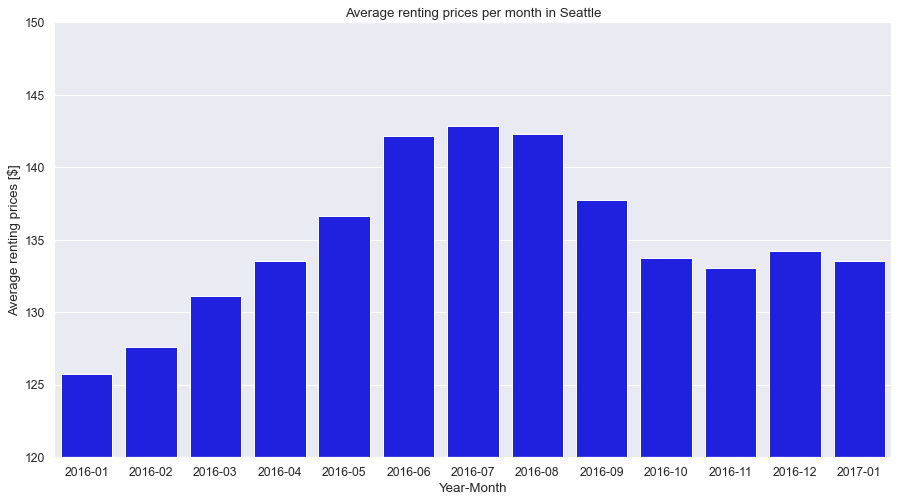

In [19]:
# Plot The average renting prices per month in Seatlle 
plt.figure(figsize = (15,8))
sns.set(font_scale = 1.11)
plot = sns.barplot(x = season["date_year_month"], y = season["price"], color = "blue")
plot.set(ylim = (120,150), title = "Average renting prices per month in Seattle", xlabel = "Year-Month", ylabel = "Average renting prices [$]");


#### Anwer to Question 1:

Prices spike in the months June, July and August (Summer months)

###  Question 2. Which areas of the city are most affected by the price spike?

In order to answer this question, we need the average price of the ares per month in summer months and compare it ith the average price of the area over the whole timespan

**Analyze** - average prices by time and area

In [20]:
# Average price per month and area
season_area = calendar[["price", "date_year_month", "area"]].groupby(by = ["area","date_year_month"]).mean().reset_index()
season_area.head()


,area,date_year_month,price
0,Ballard,2016-01,119.599534
1,Ballard,2016-02,120.018141
2,Ballard,2016-03,122.718794
3,Ballard,2016-04,124.892609
4,Ballard,2016-05,127.945722


In [21]:
# Average price per area
average_price_area = calendar[["price", "area"]].groupby(by = ["area"]).mean().reset_index()
average_price_area.head()

,area,price
0,Ballard,127.077844
1,Beacon Hill,97.183237
2,Capitol Hill,134.778449
3,Cascade,142.997014
4,Central Area,133.375261


In [22]:
# Average prices in summer months per area
area_mean_price_month = season_area[season_area["date_year_month"].isin(["2016-06", "2016-07", "2016-08"])][["area", "price"]].groupby(by = "area").mean().reset_index().sort_values(by = "price", ascending=False)
area_mean_price_month.head()

,area,price
6,Downtown,198.464708
9,Magnolia,194.859246
12,Queen Anne,171.236336
16,West Seattle,153.797669
3,Cascade,146.488563


In [23]:
# Comparison between Average price over summer months and average price of the area over the whole timespan
# To compare we divide the average price by area over the summer months by the overall average price over the whole year --> "effect" which is the proportion
area_mean_avg_price_month = pd.merge(left = area_mean_price_month, right = average_price_area, how = "left", on = "area")

area_mean_avg_price_month["effect"] = area_mean_avg_price_month["price_x"]/area_mean_avg_price_month["price_y"]
area_mean_avg_price_month= area_mean_avg_price_month.rename(columns={"price_x": "Average price in June/July/August", "price_y":"Average price over whole year"})

In [24]:
# Average price over the whole year campared with average price of the summer months June, July and August
area_mean_avg_price_month.sort_values(by="effect", ascending=False).head(8)

,area,Average price in June/July/August,Average price over whole year,effect
0,Downtown,198.464708,174.704714,1.136001
3,West Seattle,153.797669,146.522896,1.049649
7,Ballard,132.946597,127.077844,1.046182
8,Other areas,131.417925,126.192516,1.041408
15,Northgate,95.911622,92.166712,1.040632
14,Lake City,98.605526,94.825843,1.039859
2,Queen Anne,171.236336,164.708670,1.039632
13,Rainier Valley,99.513568,95.748876,1.039318


**Visualize** - the seasonal effect on average prices

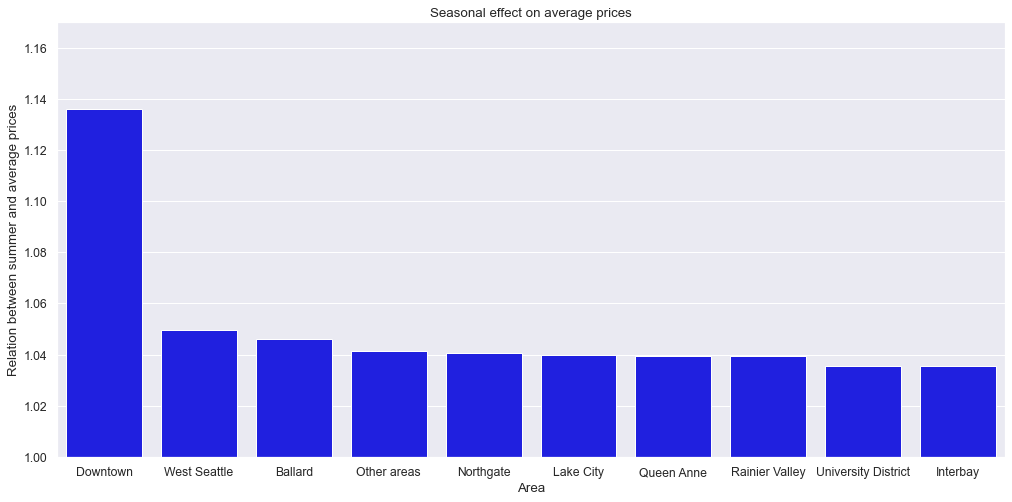

In [25]:
# Plot of the seasonal effect on prices in different areas
df = area_mean_avg_price_month.sort_values(by="effect", ascending=False)

x_plot = df["area"]
y_plot = df["effect"]

plt.figure(figsize = (17,8))
sns.set(font_scale = 1.11)
plot = sns.barplot(x=x_plot[:10], y = y_plot[:10], color="blue")
plot.set(ylim = (1,1.17), title = "Seasonal effect on average prices", xlabel = "Area", ylabel = "Relation between summer and average prices");


Appartments in Downtown Seattle are 13,6% higher in price in the summer months of June, July and August compared to the average price over the whole year

To visualize this, we plot the same bar plot as above again just for Downtown and see look for the price difference in summer months

In [26]:
# Average prices per month in Downtown Seattle
Downtown = calendar[["date_year_month", "price", "area"]][calendar["area"] == "Downtown"].groupby(by = ["date_year_month", "area"]).mean().reset_index()
Downtown

,date_year_month,area,price
0,2016-01,Downtown,149.787871
1,2016-02,Downtown,152.370982
2,2016-03,Downtown,165.450822
3,2016-04,Downtown,170.263648
4,2016-05,Downtown,179.068716
5,2016-06,Downtown,199.197044
6,2016-07,Downtown,199.046379
7,2016-08,Downtown,197.150700
8,2016-09,Downtown,178.845535
9,2016-10,Downtown,167.880706


**Visualize** - the average prices of the area most affected by the seasonal effect

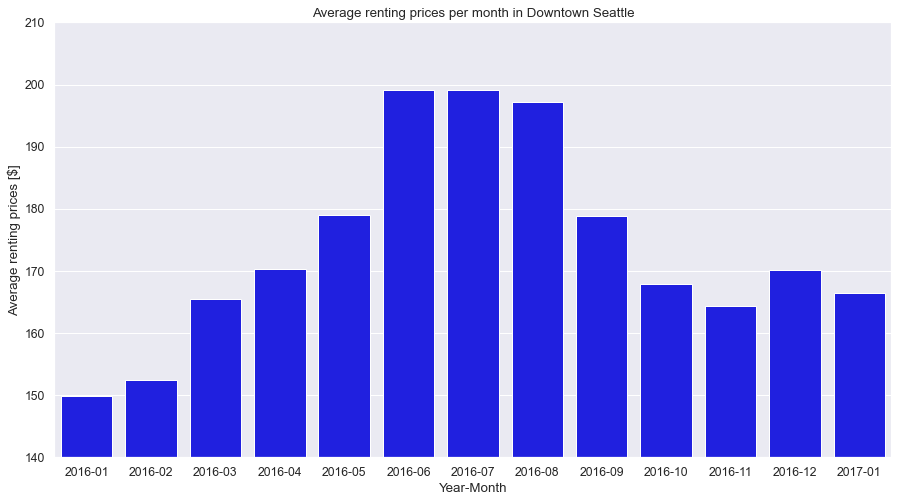

In [27]:
# Plot of average prices per month in Downtown Seattle
plt.figure(figsize = (15,8))
sns.set(font_scale = 1.11)
plot = sns.barplot(x = Downtown["date_year_month"], y = Downtown["price"], color = "blue")
plot.set(ylim = (140,210), title = "Average renting prices per month in Downtown Seattle", xlabel = "Year-Month", ylabel = "Average renting prices [$]");


#### Answer to Question 2

The area most affected by the price spike is Downtown Seattle.

### Question 3: Which attributes have the biggest impact on prices?

**Analyze** - the attributes used in the regression model

In [28]:
# Predict
y_pred_test = lm_model.predict(X_test)
y_pred_train = lm_model.predict(X_train)

# Calculate r2 for train and test samples
r2_test = r2_score(y_test,y_pred_test)
r2_train = r2_score(y_train,y_pred_train)

In [29]:
# R-squared of the test data set
r2_test

0.5475810682503601

In [30]:
# R-squares of the train dataset
r2_train

0.5440804864198202

In [31]:
# Coefficients of the Regression
Coeff = pd.DataFrame(data = lm_model.coef_, index = X_train.columns.to_list(), columns = ["Coefficients"]).reset_index()

In [32]:
# Show the coefficients that have the most impact on high prices 

Coeff = Coeff.sort_values(by = ['Coefficients'], ascending = False)
Coeff = Coeff.rename(columns = {"index":"Variables"})
Coeff.head(12)

,Variables,Coefficients
18,area_Downtown,34.829551
20,area_Magnolia,31.531152
32,property_type_Loft,30.906852
7,bedrooms,27.520637
6,bathrooms,27.411965
23,area_Queen Anne,26.508005
15,area_Cascade,25.843812
37,bed_type_Real Bed,25.804004
29,property_type_Cabin,18.792226
5,accommodates,15.506518


In [33]:
# Show the coefficients with the most negative impact on prices
Coeff.sort_values(by = "Coefficients", ascending = True).head(12)

,Variables,Coefficients
21,area_Northgate,-32.804185
17,area_Delridge,-31.688218
24,area_Rainier Valley,-27.141980
13,area_Beacon Hill,-19.257938
25,area_Seward Park,-18.071088
19,area_Lake City,-14.062221
26,area_University District,-13.592005
22,area_Other areas,-8.046481
16,area_Central Area,-7.846430
31,property_type_House,-6.716084


#### Answer to Question 3

The attribute with the highest impact on the price in general appeared to be the location of the living space. The most valuable location for a living space is Downtown Seattle followed by Magnolia neighbourhood while the cheapest areas are Northgate and Delridge. For the property type, a living space is most valuable for visitors if it is a loft apartment. Furthermore, the more bathrooms and bedrooms an apartment has, the more expensive it will be. Interestingly the fact that the host is a superhost appears to lead to a premium in price due to its positive coefficient.